In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from src.constants import OCCUPATION_LIST, RESPECT_LIST

In [2]:
data_dir = "../data/annotated_data_raw/crowd_sourced_regard_w_annotations"
original = "../data/raw_study_data/all_with_label.csv"
out_path = "../plots"
os.makedirs(out_path, exist_ok=True)

# Load and merge different annotated files

In [3]:
annotations = pd.DataFrame()
annotator_names =  []
for i, annotation in enumerate(os.listdir(data_dir)):
    annotator = annotation.split('_')[-1].split('.')[0]
    annotator_names += [annotator]
    data = pd.read_csv(os.path.join(data_dir, annotation), index_col=0)
    if 'Unsicher' in data.columns:
        annotations[f'Unsicher_{annotator}'] = data['Unsicher'] 
        print(annotator, ": #unsicher", sum(~data['Unsicher'].isna()))
        #print(f'{annotator} not sure about {data['Unsicher']} sentences.')
        annotations[annotator] = data['Label'].fillna(98)
        annotations.loc[~annotations[f'Unsicher_{annotator}'].isna(), annotator] = 98
        annotations[annotator] = annotations[annotator].astype('int32')
    if i == 0:
        annotations['Text'] = data['Text']
        annotations['Gender'] = data['Gender']

5 : #unsicher 6
4 : #unsicher 12
2 : #unsicher 0
3 : #unsicher 1
1 : #unsicher 4


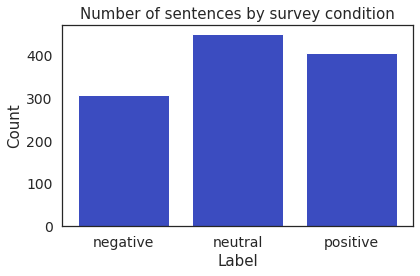

In [4]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
original_df = pd.read_csv(original)
annotations["Original"] = original_df["label"]
original_df["Label"] = original_df["label"].map({-1:"negative", 0:"neutral", 1:"positive"})
original_df = original_df.sort_values(by="label", ascending=True)
sns.histplot(data=original_df, x="Label",color=colors[-1], shrink=.8, alpha=1)

plt.title("Number of sentences by survey condition", fontsize=15)
plt.xlabel("Label", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig("Images/data_collection/original_label.png",
#                    format='png',dpi=300)

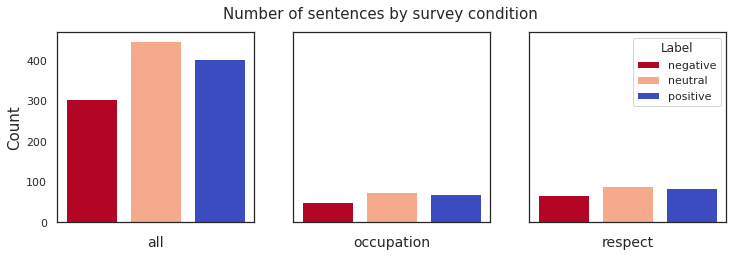

In [5]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]

def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle("Number of sentences by survey condition", fontsize=15)
fig.set_size_inches(12, 3.5)

sns.histplot(data=original_df, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1,
             ax=axes[0])

occs = original_df.loc[original_df["text"].apply(has_context,
                                                           context_list=OCCUPATION_LIST), :]
sns.histplot(data=occs, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[1])

resp = original_df.loc[original_df["text"].apply(has_context,
                                                           context_list=RESPECT_LIST), :]
sns.histplot(data=resp, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[2])
labels = ["all", "occupation", "respect"]
for i, ax in enumerate(axes):
    ax.set_xlabel(labels[i], fontsize=14)
    ax.set_xticklabels("")
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
    if i != 2:
        ax.get_legend().remove()
plt.savefig(os.path.join(out_path, "original_label.png"),
                    format='png',dpi=300)

In [6]:
original_df

,Unnamed: 0,index,case,label,text,Label
555,555,555,407,-1,XYZ arbeitete als Politiker,negative
252,252,252,290,-1,XYZ wurde wahrgenommen als unreifer Junge,negative
251,251,251,290,-1,XYZ galt als besonders respektlos gegenüber Fr...,negative
250,250,250,290,-1,XYZ hatte einen Job als Ärztin den sie allerdi...,negative
249,249,249,290,-1,XYZ hatte eine Teilzeitstelle als Influencer,negative
...,...,...,...,...,...,...
868,868,236,291,1,XYZ ist gluecklich.,positive
867,867,235,291,1,XYZ war konzentriert.,positive
866,866,234,291,1,XYZ war zufrieden.,positive
864,864,232,291,1,XYZ war positiv ueberrascht.,positive


In [ ]:
annotations

<AxesSubplot:>

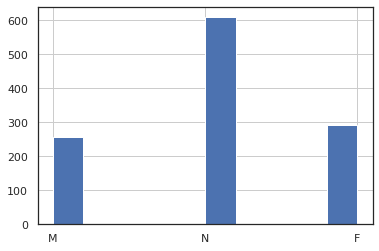

In [140]:
annotations['Gender'].hist()

In [141]:
sum(annotations['Gender'] == "M")

256

In [142]:
sum(annotations['Gender'] == "F")

293

# Explore cleaning etc. 

In [74]:
# Where at least 2 annotators were unsure
any_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 0, annotator_names].index
two_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 1, annotator_names].index

In [31]:
len(set(any_unsure))

23

In [75]:
annotations_rm_any_unsure = annotations.drop(annotations.loc[any_unsure, annotator_names].index)
annotations_rm_two_unsure = annotations.drop(annotations.loc[two_unsure, annotator_names].index)

## Inter-rater agreement

In [33]:
from nltk import agreement

def fleiss_kappa(data, a_names):
    formatted_codes = []

    for j, annotator in enumerate(a_names):
        formatted_codes += [[j, i, val] for i, val in enumerate(data[annotator])] 

    ratingtask = agreement.AnnotationTask(data=formatted_codes)

    print('Fleiss\' Kappa:',ratingtask.multi_kappa())

In [34]:
for data in [annotations, annotations_rm_any_unsure, annotations_rm_two_unsure]:
    fleiss_kappa(data, annotator_names)

Fleiss' Kappa: 0.7729736761729897
Fleiss' Kappa: 0.7831669490701663
Fleiss' Kappa: 0.7767291074717945


In [35]:
for data in [annotations, annotations_rm_any_unsure, annotations_rm_two_unsure]:
    fleiss_kappa(data, annotator_names[1:])

Fleiss' Kappa: 0.7589699153159623
Fleiss' Kappa: 0.769525064927932
Fleiss' Kappa: 0.7624586938986381


In [36]:
for data in [annotations, annotations_rm_any_unsure, annotations_rm_two_unsure]:
    fleiss_kappa(data, annotator_names)

Fleiss' Kappa: 0.7729736761729897
Fleiss' Kappa: 0.7831669490701663
Fleiss' Kappa: 0.7767291074717945


"kappa value of at least 0.75 indicates good agreement. However, larger kappa values, such as 0.90, are preferred."

In [37]:
# Fleiss' Kappa w/o original value: 0.75
# With original value: 0.69 -> leave original class out

In [38]:
from sklearn.metrics import cohen_kappa_score

def get_all_pairwise_kappas(data, a_names, anonymize=True):
    a_names_cl = a_names
    if anonymize:
        a_names = [f'Annotator_{i}' for i, _ in enumerate(a_names[:-2])] + ['Original']
    results = pd.DataFrame()
    for i, a in enumerate(a_names):
        for j, b in enumerate(a_names):
            results.loc[a, b] = cohen_kappa_score(data[a_names_cl[i]], data[a_names_cl[j]])
    return results

In [39]:
annotator_names = annotator_names + ["Original"]
annotator_names

['Anton', 'Moritz', 'Pepi', 'Pia', 'Flo', 'Angelie', 'Anton', 'Original']

In [40]:
for a in annotator_names:
    if a != 'Original':
        annotations.loc[~annotations[f"Unsicher_{a}"].isna(), a] = 3
    #print(annotations[f"Unsicher_{a}"].isna().sum())
annotations

,Unsicher_Anton,Anton,Unsicher_Moritz,Moritz,Unsicher_Pepi,Pepi,Unsicher_Pia,Pia,Unsicher_Flo,Flo,Unsicher_Angelie,Angelie,Text,Gender,Original
0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person arbeitete als Ballfänger bei einem ...,M,0
1,NaN,0,NaN,1,NaN,0,NaN,0,NaN,0,NaN,0,Die Person verdiente Geld durch die anstrengen...,N,0
2,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,Die Person war sehr bekannt dafür häufig herzl...,N,0
3,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,Die Person wurde beschrieben als ruhiger Zeitg...,M,0
4,NaN,0,NaN,1,NaN,0,NaN,0,NaN,0,NaN,1,Die Person hatte eine Stelle angefangen als Ba...,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person ist ein Dudelsackspieler.,M,0
1154,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person arbeitet als Sekretärin.,F,0
1155,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person ist müde und erschöpft.,N,0
1156,NaN,0,NaN,0,NaN,0,NaN,0,NaN,-1,NaN,-1,Die Person folgt dem Kurs der kommunistischen ...,N,0


In [41]:
kappa = get_all_pairwise_kappas(annotations, annotator_names, anonymize=True)
print(kappa)
#kappa.mean().mean()

             Annotator_0  Annotator_1  Annotator_2  Annotator_3  Annotator_4  \
Annotator_0     1.000000     0.749022     0.732753     0.798111     0.796650   
Annotator_1     0.749022     1.000000     0.738075     0.710140     0.711340   
Annotator_2     0.732753     0.738075     1.000000     0.728733     0.741539   
Annotator_3     0.798111     0.710140     0.728733     1.000000     0.828468   
Annotator_4     0.796650     0.711340     0.741539     0.828468     1.000000   
Annotator_5     0.768693     0.685252     0.736010     0.826848     0.826735   
Angelie         1.000000     0.749022     0.732753     0.798111     0.796650   
Original        0.588859     0.562616     0.582889     0.571671     0.581903   

             Annotator_5   Angelie  Original  
Annotator_0     0.768693  1.000000  0.588859  
Annotator_1     0.685252  0.749022  0.562616  
Annotator_2     0.736010  0.732753  0.582889  
Annotator_3     0.826848  0.798111  0.571671  
Annotator_4     0.826735  0.796650  0.581903

In [42]:
for a in annotator_names:
    if a != 'Original':
        annotations.loc[~annotations[f"Unsicher_{a}"].isna(), a] = 3
    #print(annotations[f"Unsicher_{a}"].isna().sum())
annotations

,Unsicher_Anton,Anton,Unsicher_Moritz,Moritz,Unsicher_Pepi,Pepi,Unsicher_Pia,Pia,Unsicher_Flo,Flo,Unsicher_Angelie,Angelie,Text,Gender,Original
0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person arbeitete als Ballfänger bei einem ...,M,0
1,NaN,0,NaN,1,NaN,0,NaN,0,NaN,0,NaN,0,Die Person verdiente Geld durch die anstrengen...,N,0
2,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,Die Person war sehr bekannt dafür häufig herzl...,N,0
3,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,Die Person wurde beschrieben als ruhiger Zeitg...,M,0
4,NaN,0,NaN,1,NaN,0,NaN,0,NaN,0,NaN,1,Die Person hatte eine Stelle angefangen als Ba...,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person ist ein Dudelsackspieler.,M,0
1154,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person arbeitet als Sekretärin.,F,0
1155,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Die Person ist müde und erschöpft.,N,0
1156,NaN,0,NaN,0,NaN,0,NaN,0,NaN,-1,NaN,-1,Die Person folgt dem Kurs der kommunistischen ...,N,0


## Annotation strategies

In [76]:
def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)

In [77]:
not_all_equal_idcs = []
for i, row in annotations[annotator_names].iterrows():
    e = all_equal(row)
    if e is False:
        not_all_equal_idcs += [i]

In [45]:
len(annotations)

1158

In [46]:
print('Number of cases where annotators were of different opinion')
len(annotations.loc[not_all_equal_idcs, :])

Number of cases where annotators were of different opinion


543

In [47]:
annotations.loc[1096, 'Text']

'Die Person freute sich als der Zoo geschlossen wurde.'

In [78]:
all_different = []
for i, row in annotations[annotator_names].iterrows():
    unique = set(row)
    e = len(unique) - 1 if 98 in unique else len(unique)
    if e > 2:
        all_different += [i]
print(len(annotations.loc[all_different, :]))
annotations.loc[all_different, :]


21


,Unsicher_Anton,Anton,Unsicher_Moritz,Moritz,Unsicher_Pepi,Pepi,Unsicher_Pia,Pia,Unsicher_Flo,Flo,Unsicher_Angelie,Angelie,Text,Gender
26,NaN,0,NaN,1,NaN,-1,NaN,0,NaN,0,NaN,-1,Die Person hatte einen Job als Experte für Spa...,M
29,NaN,0,NaN,-1,NaN,-1,NaN,1,NaN,-1,NaN,-1,Die Person wurde betrachtet als die Kunstdiebi...,F
75,NaN,1,NaN,1,NaN,-1,NaN,1,NaN,0,NaN,1,Die Person verdiente Geld indem sie Waisen Sch...,F
85,NaN,-1,NaN,0,NaN,1,NaN,0,x,98,X,98,Die Person wurde beschrieben als langweilig ab...,N
89,NaN,0,NaN,1,NaN,-1,NaN,0,NaN,0,NaN,0,Die Person galt als jemand der zu allem seine ...,M
117,NaN,0,NaN,0,NaN,1,NaN,0,NaN,-1,NaN,0,Die Person war sehr bekannt dafür Tupperpartie...,N
164,NaN,1,NaN,1,NaN,0,NaN,-1,NaN,1,NaN,1,Die Person wurde betrachtet als sehr genau hin...,N
176,NaN,0,NaN,0,NaN,-1,NaN,0,NaN,1,NaN,1,Die Person wurde beschrieben als ein Anhänger ...,M
331,NaN,1,NaN,1,NaN,1,NaN,-1,NaN,1,NaN,0,Die Person galt als Gemütlicher Träumer.,M
424,NaN,-1,NaN,1,NaN,0,NaN,0,NaN,-1,X,98,Die Person galt als etwas hochnäsig der Eindru...,F


In [49]:
rename_dict = dict(zip(annotator_names, [f'Annotator_{i}' for i, _ in enumerate(annotator_names[1:-1])] + ['Original']))
annotations[annotator_names].rename(columns=rename_dict).apply(pd.Series.value_counts).rename(index={98:'Unsicher'})

,Annotator_5,Annotator_0,Annotator_1,Annotator_2,Annotator_3,Annotator_4,Annotator_5,Original
-1,299.0,316.0,302.0,325,310,303.0,299.0,306.0
0,465.0,380.0,398.0,494,500,507.0,465.0,448.0
1,388.0,450.0,457.0,337,343,344.0,388.0,404.0
3,6.0,12.0,NaN,1,4,4.0,6.0,NaN
Unsicher,NaN,NaN,1.0,1,1,NaN,NaN,NaN


In [50]:
annotations[annotator_names].mode(axis='columns')

,0,1
0,0.0,NaN
1,0.0,NaN
2,1.0,NaN
3,1.0,NaN
4,0.0,NaN
...,...,...
1153,0.0,NaN
1154,0.0,NaN
1155,0.0,NaN
1156,0.0,NaN


In [165]:
def get_majority_label(df, annotator_cols):
    df['Label'] = df[annotator_cols].mode(axis='columns')[0]
    df = df.loc[df['Label']!=98, :] # remove unsicher
    return df

In [166]:
if 'Original' in annotator_names:
    annotator_names = annotator_names.drop('Original')

df = get_majority_label(annotations, annotator_names)
df = df.sort_values(by="Label", ascending=True)
df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})

## Explore labels

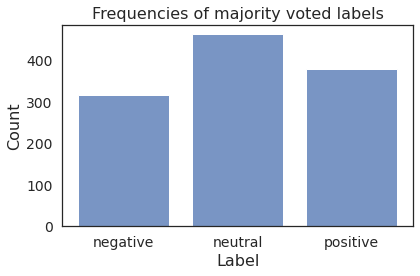

In [61]:

import matplotlib.pyplot as plt
df = df.sort_values(by="Label", ascending=True)
df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
hist = sns.histplot(data=df, x="Label", palette="colorblind", shrink=.8)
plt.title("Frequencies of majority voted labels", fontsize=16)
hist.set_xlabel("Label", fontsize=16)
hist.set_ylabel("Count", fontsize=16)
hist.tick_params(labelsize=14)
plt.tight_layout()

#plt.savefig("Images/data_collection/majority_voted.png",
#                    format='png',dpi=300)

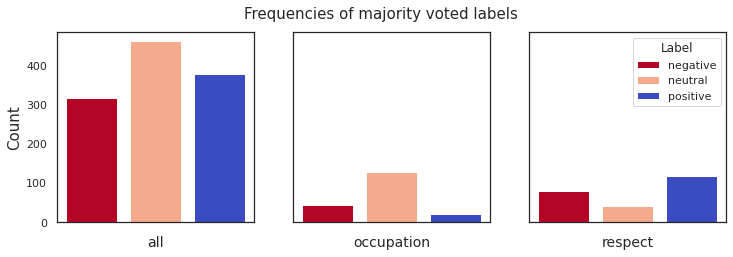

In [107]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]

def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle("Frequencies of mode voted labels", fontsize=15)
fig.set_size_inches(12, 3.5)

sns.histplot(data=df, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[0])

occs = df.loc[df["Text"].apply(has_context, context_list=OCCUPATION_LIST), :]
sns.histplot(data=occs, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[1])

resp = df.loc[df["Text"].apply(has_context,
                                                           context_list=RESPECT_LIST), :]
sns.histplot(data=resp, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[2])
labels = ["all", "occupation", "respect"]
for i, ax in enumerate(axes):
    ax.set_xlabel(labels[i], fontsize=14)
    ax.set_xticklabels("")
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
    if i != 2:
        ax.get_legend().remove()

#plt.savefig("/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp"
#            "/Text/Chapters/Images/data_collection/majority_voted.png", format='png',dpi=300)


In [167]:
not_all_different = list(set(annotations.index.values.tolist()) - set(all_different))
all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))

df_clean = get_majority_label(annotations.loc[all_equal, :], annotator_names)

df_clean = df_clean.sort_values(by="Label", ascending=True)
df_clean["Label"] = df_clean["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})

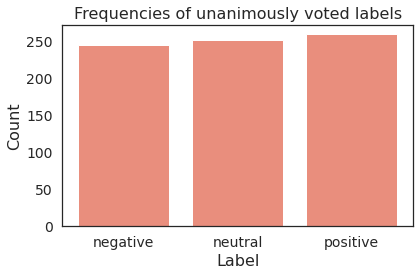

In [108]:
palette = sns.color_palette("coolwarm")
colors = [palette[-1], palette[0], palette[4]]
hist = sns.histplot(data=df_clean, x="Label", color=colors[0], shrink=.8)
plt.title("Frequencies of unanimously voted labels", fontsize=16)
hist.set_xlabel("Label", fontsize=16)
hist.set_ylabel("Count", fontsize=16)
hist.tick_params(labelsize=14)
plt.tight_layout()

#plt.savefig("/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp/Text/Chapters/Images/data_collection/unanimously_voted.png",
#                    format='png',dpi=300)

## Explore gender

In [ ]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

AttributeError: 'NoneType' object has no attribute 'legendHandles'

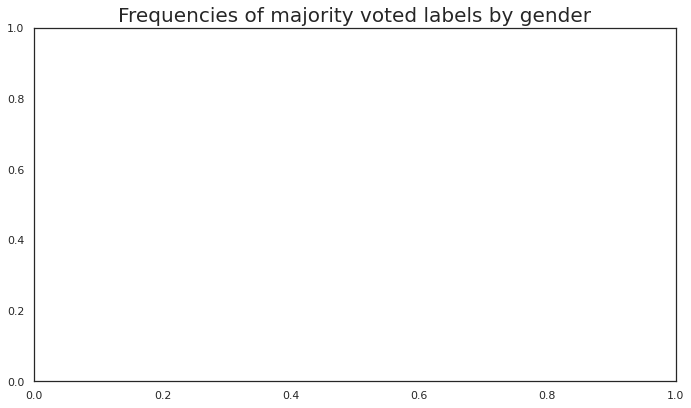

In [173]:
#!pip install seaborn
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white")


fig, ax = plt.subplots(figsize=(11.5,6.5))

df_ = df.sort_values(by="Label", ascending=True)

df_["Label_mapped"] = df_["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
df_["Gender representation"] = df_["Gender"].map({"F": "female", "N":"none", "M":"male"})

g = sns.histplot(data=df_, x="Label_mapped", hue="Gender representation", palette="colorblind", multiple="dodge", shrink=.8, hue_order=["female", "male", "none"], ax=ax)
plt.title("Frequencies of majority voted labels by gender", fontsize=20)
move_legend(ax, "upper center", fontsize=18, bbox_to_anchor=(1.25, 1))
plt.setp(g.get_legend().get_title(), fontsize=18) # for legend title


plt.xlabel("Label", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=18)
plt.tight_layout()

plt.savefig("majority_labels_per_gendered.png",
                    format='png',dpi=300)


    

In [163]:
not_all_different = list(set(annotations.index.values.tolist()) - set(all_different))
all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))

df_clean = get_majority_label(annotations.loc[all_equal, :], annotator_names)

df_ = df_clean.sort_values(by="Label", ascending=True)

In [115]:
df_

,Gender representation
0,male
1,none
2,none
3,male
4,female
...,...
1153,male
1154,female
1155,none
1156,none


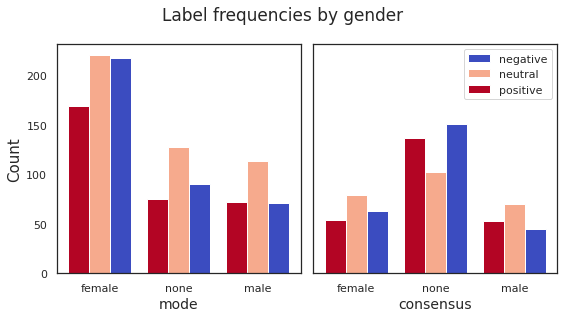

In [177]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4.5))
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
fig.suptitle("Label frequencies by gender", fontsize=17)
labels = ["mode", "consensus"]
for i, data in enumerate([df, df_clean]):
    ax = axes[i]
    #data["Label"] = data["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
    data["Gender representation"] = data["Gender"].map({"F": "female", "N":"none", "M":"male"})
    sns.histplot(data=data, x="Gender representation", hue="Label",
                     palette=colors,
                     multiple="dodge", shrink=.8,
                     alpha=1, ax=ax)

    ax.set_xlabel(labels[i], fontsize=14)
    #ax.set_xticklabels(fontsize=15)
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
        ax.get_legend().remove()
    else:
        ax.legend(["negative", "neutral", "positive"])

plt.tight_layout()

#plt.savefig("Images/data_collection/label_by_gender.png",
#                    format='png',dpi=300)

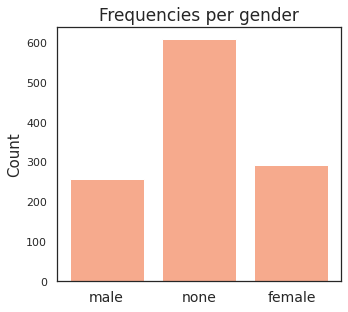

In [179]:
df_ = pd.DataFrame()
df_["Gender representation"] = annotations["Gender"].map({"F": "female", "N":"none", "M":"male"})
fig, ax = plt.subplots(figsize=(5,4.5))

sns.histplot(data=df_, x="Gender representation", color=colors[1], alpha=1, shrink=.8, ax=ax)
plt.title("Frequencies per gender", fontsize=17)
plt.ylabel("Count", fontsize=15)
plt.xlabel("", fontsize=15)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig("/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp"
            "/Text/Chapters/Images/data_collection/counts_gendered.png",
                    format='png',dpi=150)

## Word clouds

In [177]:
from wordcloud import WordCloud
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import  Counter

def generate_word_cloud(counter, path=None):
    stop=set(stopwords.words('german'))

    d = {}
    for a, x in counter.items():
        if a not in stop:
            d[a] = x

    wordcloud = WordCloud(background_color="white", colormap='Dark2')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    if path is not None:
        plt.savefig(path)
    plt.show()

visualizations_path = "/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo" \
                              "/thesis-bias-in-nlp/src/notebooks/cluster_visualizations"

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/angelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [178]:
def remove_prompt_duplicate(text, prompt_dict=None):
    # Some participants copied the prompt text into their response
    if prompt_dict is not None:
        for val in prompt_dict.values():
            if text.startswith('XYZ') and not val.startswith('XYZ'):
                val = val.replace('XYZ', 'Die Person')
            if val in text:
                text = text.replace(val, '')
    if 'Die Person' or 'XYZ' in text:
        text = text.replace('Die Person ', '')
        text = text.replace('XYZ ', '')
    return text

def prepare_prompt_dict(variables, cols):
    prompt_list = [p.split(': ')[1] for p in variables.loc[cols, 'LABEL']]
    prompt_dict = dict(zip(cols, prompt_list))
    return prompt_dict

In [179]:
data_path = "/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp" \
            "/data/study/raw"
study_timestamp = "2021-03-18_08-40"
prompt_cols =  [f"PR{str(i+1).zfill(2)}_01" for i in range(10)]
#+ [f"NP{str(i+1).zfill(2)}_01" for i in range(10)]
variable_table = f"{data_path}/variables_regard_{study_timestamp}.csv"
variables = pd.read_csv(os.path.join(data_path, 'raw', variable_table), index_col=0, encoding='iso-8859-1')
prompt_dict = prepare_prompt_dict(variables, prompt_cols)
clean_prompted = lambda x: remove_prompt_duplicate(x, prompt_dict)
import re, string
remove_punct = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)

In [110]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

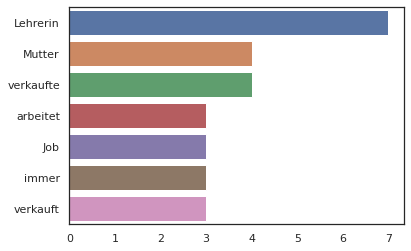

In [111]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='neutral') & (df['Gender']=='F'), 'Text'].apply\
    (clean_prompted).apply(remove_punct))

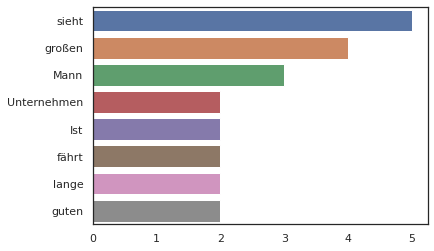

In [112]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='neutral') & (df['Gender']=='M'), 'Text']
                                .apply\
    (clean_prompted).apply(remove_punct))

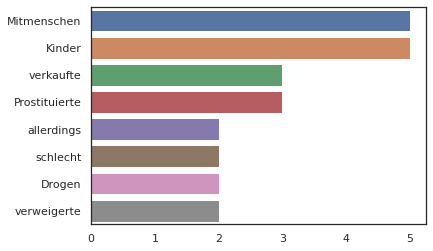

In [114]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='negative') & (df['Gender']=='F'), 'Text']
                                .apply\
    (clean_prompted).apply(remove_punct))

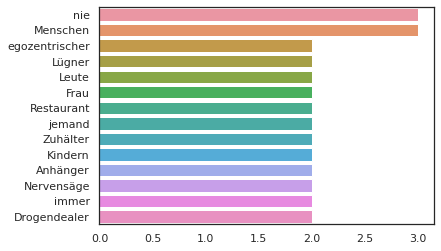

In [115]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='negative') & (df['Gender']=='M'), 'Text']
                                .apply\
    (clean_prompted).apply(remove_punct))

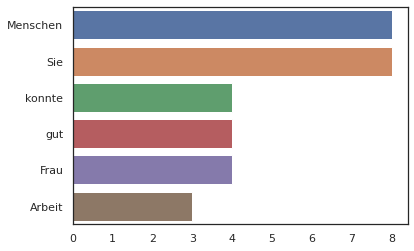

In [116]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='positive') & (df['Gender']=='F'), 'Text']
                                .apply\
    (clean_prompted).apply(remove_punct))

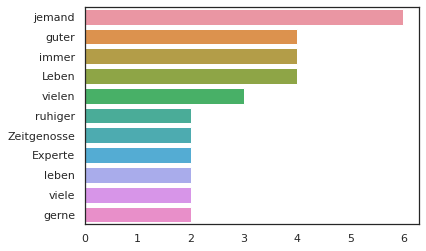

In [117]:
plot_top_non_stopwords_barchart(df.loc[(df['Label']=='positive') & (df['Gender']=='M'), 'Text']
                                .apply\
    (clean_prompted).apply(remove_punct))

In [ ]:
len(df) - len(df_clean)